<h1>BINARY SIGNAL RECOVERY</h1>

<h3>The scope of the present project is to illustrate how to recover a binary signal from noisy observations using Markov Chain Monte Carlo techniques.</h3>

***************************************************************************************************************************

<h2>Libraries</H2>

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
import seaborn as sns

<h2>Model Definition / Data Creation </h2>

Let $X ∈ R^{m×d}$ be a random sensing matrix with i.i.d. entries sampled from $N(0, 1)$.

In [2]:
m = 10 #rows of the matrix
d = 10 #columns of the matrix
#matrix with entries sampled form N(0,1)
X = np.random.normal(0,1,(m,d))
X

array([[-1.77055054,  0.84137953, -1.13486188,  2.93492566,  0.8047054 ,
         1.08796194,  0.24001461, -0.42691601,  0.54726137, -1.39601075],
       [-0.02294002, -1.52845266,  1.02815818, -1.93017667,  1.00249053,
        -0.28005464, -0.79409919, -0.50666074, -0.83201733, -0.24428135],
       [-0.13133752, -0.09438998,  0.68814016,  0.18544688, -0.42139143,
         1.11099866,  0.58585531,  0.25958072,  0.76372439,  0.88233779],
       [ 0.9777072 , -0.16103346, -0.9557562 , -1.38749776, -0.28147883,
         0.445027  ,  1.26434923,  2.5390321 , -1.32593741,  0.2326176 ],
       [-1.38489739,  0.25674252, -0.10671934,  0.67769938, -2.17601094,
         0.20663731,  1.07269617, -0.86354204,  0.20733936,  0.34508676],
       [ 0.64459979,  0.85030173,  0.6984825 ,  0.73969035,  0.95313331,
         0.68890181,  0.59527357, -0.08114874, -0.177329  , -0.32943585],
       [ 0.83245418, -2.85596866, -0.38682845,  0.21448482, -1.81778477,
         1.42833493, -0.58063413, -1.862088  

Let $\epsilon ∈ R^m$ be a noise vector, independent of $X$, with i.i.d. entries sampled from  $N(0,1)$.

In [3]:
noise = np.random.normal(0,1,m) #noise vector sampled from N(0,1)
noise

array([ 0.4509991 , -1.2045238 , -1.03033879,  2.3760469 , -0.48136353,
       -1.8897286 ,  1.35268012, -0.26027381, -0.94988785, -1.37534526])

Take  $Θ = \{0,1\}^d$ ( signal space) and let  $θ ∈ Θ$ (signal) be chosen uniformly at random and be independent of the pair $(X, ξ)$.

In [4]:
#vector of lenght d, whith valued sampled from an uniform distribuition
#np.random.choice selects uniformly at random one of the given values [0,1]
initial_theta = np.random.choice([0,1],d)
initial_theta

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])

The measurement vector  $y ∈ R^m$ is generated as: $y = Xθ + ξ$.

In [5]:
#we compute y using the equation above
X_theta = np.dot(X,initial_theta) #multiplie the matrix X for the vector theta
measurement_vector = X_theta + noise #add the noise vector to the result
measurement_vector #y

array([ 4.46651685, -6.01950644,  1.81777895,  0.17922288,  1.2121418 ,
       -0.11759957, -1.0877835 ,  5.66422901,  2.00349095,  0.59223484])

<h2>Data Creation Function</h2>

In [2]:
def data(X_rows,X_columns):
    X_matrix = np.random.normal(0,1,(X_rows,X_columns)) #matrix with elements sampled from N(0,1)
    noise_vector = np.random.normal(0,1,X_rows) #noise vector sampled from N(0,1)
    theta_0= np.random.choice([0,1],X_columns) #initial signal vector
    X_theta = np.dot(X_matrix,theta_0) #multiplie the matrix X for the vector theta
    measurement_vector = X_theta + noise_vector #add the noise vector to the result = Y
    return X_matrix, theta_0, measurement_vector

We want to recover the unknown vector $θ$ using Markov Chain Monte Carlo techniques, given the observations $(X,y)$.
We are interested in the case when $d$ is large. We recover $θ$ by finding the maximum likelihood estimate.

The maximum likelihood estimate of $θ$ is given by the value  $\hat{θ} ∈ Θ$
that maximizes the likelihood function given the observations $(X,y)$
$$
\\
\mathcal{L}(X, y; \theta) = \frac{\exp \left\{ -\frac{1}{2} (y - X\theta)^{\top} (y - X\theta) \right\}}{(2\pi)^{m/2}},
$$
We can equivalently cast the question in the form of a minimization problem.
Indeed, the maximum likelihood estimate of  $θ$ is given by the value $\hat{\theta} ∈ Θ$ that minimizes the function:

given the observations $(X, y)$:

$$
\mathcal{H}(X, y; \theta) = (y - X\theta)^\top (y - X\theta),
$$


Given a binary signal this function $H$ will measure the discrepancy between the observed data $y$ and the prediction $X\theta$, 

It measures how well the binary signal $\theta$ explains the observations $y$ and so how well a particular signal fits the data. The goal is to find $\hat{\theta}$ that minimizes this error.


<h2>H function</h2>

In [3]:
def H(theta,X,y):
    #product of X and theta
    X_theta = np.dot(X,theta)
    #compute the residuals
    residuals = y - X_theta
    #value of the function
    H_value = np.dot(residuals.T,residuals)
    return H_value

the output of the $H$ function will be a single scalar value which represents the total squared error which we want to minimize finding a $\hat{\theta}$ that minimize $H$

In [7]:
#function H example
H(initial_theta,X,measurement_vector)

13.936386723224574

<h2> Metropolis-Hasting Algorithm </h2>

The Metropolis-Hastings algorithm is a powerful method for generating samples from a probability distribution, especially when direct sampling is difficult or the distribution is unknown.

In order to find the value of $\hat{\theta}$ that minimizes $H$ with this algorithm we constructs a Markov Chain that has the desired distribution as the stationary distribution of the chain.




Let $β > 0$ be a fixed real parameter. We construct the Metropolis-Hastings (discrete-time) Markov chain on the state space $Θ$, with stationary distribution:
$$
\pi_{\beta}(\theta) = \frac{e^{-\beta \mathcal{H}(X, y; \theta)}}{Z_{\beta}}, \quad \text{with} \quad Z_{\beta} = \sum_{\theta \in \Theta} e^{-\beta \mathcal{H}(X, y; \theta)}.
$$

Where
- $H(X,y,\theta)$  is the function that measures the error or cost associated with the parameter $\theta$
- $\beta > 0$ is a parameter that controls the concentration of the distribution
- $Z_b$ is the normalizing constant to ensure that $\pi_\beta(\theta)$ is a proper probability distribution.





Why this distribution?

- The distribution $\pi_\beta(\theta)$ is designed in order to assign an high probability to the states $\theta$ where the function $H$ is lower, in particular the exponential form $e^{-\beta H(X,y,\theta)}$ ensure that $\pi_\beta(\theta)$ decreases rapidly as $H$ increase

- The role of the parameter $\beta$ is to increase the penalization given to high value of $H$, as a result the distribution assign lower probabilities to states $\theta$ where the $H$ is higher and the opposite when $H$ is lower. Hence as $\beta$ increase the distribution becomes more sharply peaked around the states that minimize $H$ (it decreases rapidly)


Observe that the probability distribution $πβ$ concentrates on the maximum likelihood estimate as $β → +∞$ Therefore, if we choose $β$  sufficiently large and we run the chain for a large number $N$ of steps, we can take the state visited at time $N$ as the maximum likelihood estimate $\hat{\theta}$.

This thanks to convergence theorem of Markov chains, which ensures that the distribution of the states visited by the chain converges to the stationary distribution when $N$ is very large

<h2>The Algorithm</h2>

### Input:
- value of the parameter $\beta$;
- number of steps $N$;
- initial state $\bar{\theta} \in \Theta$;

### Output:
- trajectory of the Metropolis-Hastings chain starting at $\bar{\theta}$;

### Procedure

**Step 1.** Set $\theta_0 = \bar{\theta}$.

**Step 2.** For $t = 1, 2, \ldots, N - 1$:

1. pick $i$ uniformly at random in $\{1, 2, \ldots, d\}$;

2. let the proposed state be $\theta^* \in \Theta$, with entries
$$
\theta^*(j) = 
\begin{cases} 
\theta_{t-1}(j) & \text{if } j \ne i \\
1 - \theta_{t-1}(j) & \text{if } j = i 
\end{cases}
\quad (j = 1, 2, \ldots, d);
$$

3. set
$$
\theta_t = 
\begin{cases} 
\theta^* & \text{with probability } \min \left\{ 1, \frac{e^{-\beta H(X, y; \theta^*)}}{e^{-\beta H(X, y; \theta_{t-1})}} \right\} \\
\theta_{t-1} & \text{with probability } 1 - \min \left\{ 1, \frac{e^{-\beta H(X, y; \theta^*)}}{e^{-\beta H(X, y; \theta_{t-1})}} \right\}
\end{cases}.
$$


In [4]:
def metropolis_hasting(beta, number_of_steps, theta, state_space_dimension, matrix, measurement_vector):
    theta_t = theta.copy()  #initialize theta0 as the initial theta

    for t in range(1,number_of_steps): #for each N

        #Step 1: Pick an index i uniformly at random in {1, 2, ..., d}
        i = np.random.randint(state_space_dimension)

        #Step 2: Propose new state theta*
        theta_star = theta_t.copy()
        theta_star[i] = 1 - theta_star[i]
        #propose a new value of the element i of the vector, if it was 0 becomes 1 and oth.

        #Calculate H(theta_t) and H(theta_star)
        H_theta_t = H(theta_t, matrix, measurement_vector)
        H_theta_star = H(theta_star, matrix, measurement_vector)
        #evaluate the performance of H which the old vector theta and the new one updated in the index i 

        #Step 3: Compute acceptance probability
        acceptance_condition = min(1, np.exp(-beta * (H_theta_star - H_theta_t)))
        #if H* < H the exp will be > 1  so we will accept for sure (min = 1)
        #if H* > H, 0< exp < 1, so the new proposal will be accepted with a certain probability  (min = value of exp)
        
        #Accept or reject the new state
        if np.random.rand() < acceptance_condition:
            theta_t = theta_star
        #if the random number is < acceptace condition we accept the new theta*
        #this acceptance condition is very important because it allows sometimes to accept worst states with greater
        #value of H. This helps the algorithm to avoid to get stuck in a local minima, and so to explore more the
        #state space increasing the probability of finding the global minimum
    return theta_t 

the role of $\beta$

it controls the acceptance of the new proposed states, in particual an high value will penalize more high value of H. So increasing $\beta$ the probability of acceptance of a worst state decrease exponentially (the algorithm will accept only states that minmize H). But increasing too much the $\beta$ can be a problem because the algo could converge rapidly into a local minima without having the possibility to explore all the states and so find the true global minima. (sub optimal results) 

<h3>Output of the Metropolis-Hasting</h3>

In [14]:
#create data starting from a 10x10 matrix, following the contranits fixed above
X, theta, y = data(10,10)

In [15]:
B = 1.0 #value of beta
N = 100 #number of steps

metropolis_hasting(B, N, theta, 10, X, y)

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 1])

<h3>Estimating the quality of the prediction using the Law of large number</h3>

By implementing the Metropolis-Hastings algorithm above, we determine an estimate $\hat{\theta}$ of a signal $\theta \in \Theta$ for any given realization of $(X,y)$. To check the quality of our estimate, we analyze the mean squared error

$$
\mathcal{E} = \mathbb{E} \left( (\hat{\theta} - \theta)^{\top} (\hat{\theta} - \theta) \right),
$$

where the expectation is over $\theta$ and $(X,y)$, for different values of $m$ (number of measurements). Fix $d = 10$. For every $1 \leq m \leq 15$, compute the mean squared error. Plot $\mathcal{E}$ as a function of $m$ and comment on the characteristics of your plot. What is the minimum value of $\frac{m}{d}$ required to reliably recover $\theta$?

**Remark.** The mean squared error $\mathcal{E}$ can be estimated by exploiting the law of large numbers. Let $M$ denote the number of independent realizations of $(\theta, X, y)$. Moreover, let $\hat{\theta}^{(j)}$ be the maximum likelihood estimate of the $j$-th signal $\theta^{(j)}$, obtained by the $j$-th run of the Metropolis-Hastings algorithm, given $(X^{(j)}, y^{(j)})$. If $M$ is sufficiently large (use $M$ of order $10^4$), then we have the approximation

$$
\mathcal{E} \approx \frac{1}{M} \sum_{j=1}^{M} \left( (\hat{\theta}^{(j)} - \theta^{(j)})^{\top} (\hat{\theta}^{(j)} - \theta^{(j)}) \right).
$$


In [5]:
#function to compute the product of the resesiduals, it will be useful for computing the MSE
def product_residuals(signal_pred, initial_signal):
    residual = signal_pred - initial_signal
    product = np.dot(residual.T,residual)
    return product

In [7]:
#MSE
def mean_sq_error(matrix_max_rows,realizations, beta, number_of_steps, state_space_dimension):
    mse_for_different_m = []

    for n_rows in range(1,matrix_max_rows+1): #for every dimension of the matrix (dimension da 1 a 15)
        
        sum_of_product_residuals = 0 #for the choice dimension of the matrix
        
        for i in range(realizations):
            X, initial_theta, y = data(n_rows,d)
            binary_signal_pred = metropolis_hasting(beta, number_of_steps, initial_theta, state_space_dimension,X,y)
            prod_residual_j = product_residuals(binary_signal_pred, initial_theta)
            sum_of_product_residuals += prod_residual_j
            
        error = sum_of_product_residuals / realizations
        mse_for_different_m.append(error)
        print(f'MSE m={n_rows}: {mse_for_different_m[n_rows-1]}')
        
    return mse_for_different_m

<h3>Checking the quality of the estimations</h3>

In [19]:
M = 10000 #number of realization of the metropolis-hasting
B = 1.0 #value of beta 
N = 100 #number of steps of the metropolis-hasting
d = 10 #state space dimension
max_row_matrix = 15

MSE = mean_sq_error(max_row_matrix,M, B, N,d)
print(MSE)

MSE m=1: 4.5644
MSE m=2: 4.0705
MSE m=3: 3.5731
MSE m=4: 3.0952
MSE m=5: 2.6608
MSE m=6: 2.2094
MSE m=7: 1.8583
MSE m=8: 1.5889
MSE m=9: 1.3678
MSE m=10: 1.1183
MSE m=11: 0.9555
MSE m=12: 0.8372
MSE m=13: 0.7172
MSE m=14: 0.5997
MSE m=15: 0.5137
[4.5644, 4.0705, 3.5731, 3.0952, 2.6608, 2.2094, 1.8583, 1.5889, 1.3678, 1.1183, 0.9555, 0.8372, 0.7172, 0.5997, 0.5137]


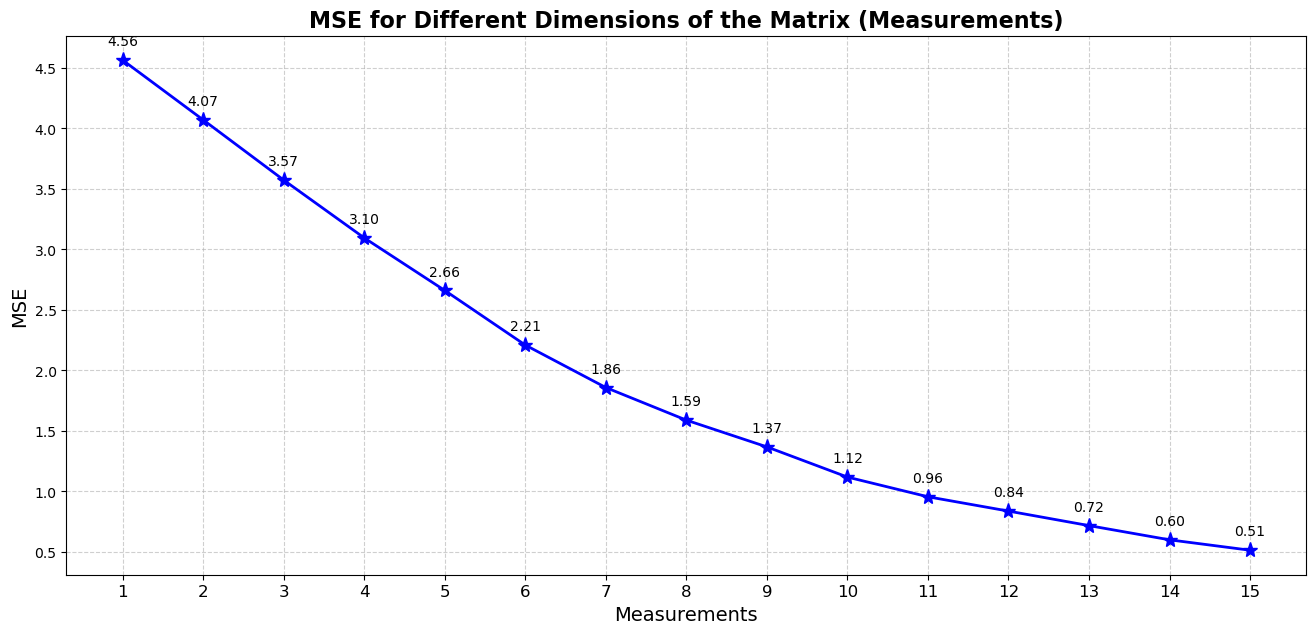

In [38]:
#plotting the MSE (E) as function of m

matrix_dimension = list(range(1,16))
plt.figure(figsize=(16, 7))
plt.plot(matrix_dimension, MSE, marker='*', linestyle='-', color='b', markersize=11, linewidth=2)
plt.title('MSE for Different Dimensions of the Matrix (Measurements)', fontsize=16, fontweight='bold')
plt.xticks(matrix_dimension, fontsize=12)
plt.xlabel('Measurements', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(matrix_dimension)

for i, value in enumerate(MSE):
    plt.text(matrix_dimension[i], value + 0.12, f'{value:.2f}', fontsize=10, ha='center')
plt.show()

When the dimension of the matrix $X$ increase the MSE decrease. 

<h3>Analisys with respect to different values of B</H3>

MSE m=1: 4.6492
MSE m=2: 4.312
MSE m=3: 3.9509
MSE m=4: 3.612
MSE m=5: 3.2596
MSE m=6: 2.8624
MSE m=7: 2.5476
MSE m=8: 2.2307
MSE m=9: 1.9421
MSE m=10: 1.6466
MSE m=11: 1.4369
MSE m=12: 1.222
MSE m=13: 1.0687
MSE m=14: 0.909
MSE m=15: 0.783
MSE m=1: 4.5713
MSE m=2: 4.0785
MSE m=3: 3.6132
MSE m=4: 3.0578
MSE m=5: 2.6215
MSE m=6: 2.2466
MSE m=7: 1.8873
MSE m=8: 1.5918
MSE m=9: 1.3288
MSE m=10: 1.1232
MSE m=11: 0.9621
MSE m=12: 0.8278
MSE m=13: 0.6823
MSE m=14: 0.6071
MSE m=15: 0.5053
MSE m=1: 4.4668
MSE m=2: 3.8667
MSE m=3: 3.2732
MSE m=4: 2.6826
MSE m=5: 2.2754
MSE m=6: 1.8762
MSE m=7: 1.5861
MSE m=8: 1.3334
MSE m=9: 1.1467
MSE m=10: 0.979
MSE m=11: 0.8443
MSE m=12: 0.6998
MSE m=13: 0.6148
MSE m=14: 0.5228
MSE m=15: 0.448
MSE m=1: 4.3455
MSE m=2: 3.624
MSE m=3: 2.9884
MSE m=4: 2.4254
MSE m=5: 2.0327
MSE m=6: 1.7166
MSE m=7: 1.4448
MSE m=8: 1.2449
MSE m=9: 1.0532
MSE m=10: 0.9042
MSE m=11: 0.7733
MSE m=12: 0.6633
MSE m=13: 0.56
MSE m=14: 0.4769
MSE m=15: 0.4023
MSE m=1: 4.2443
MSE m=2: 3

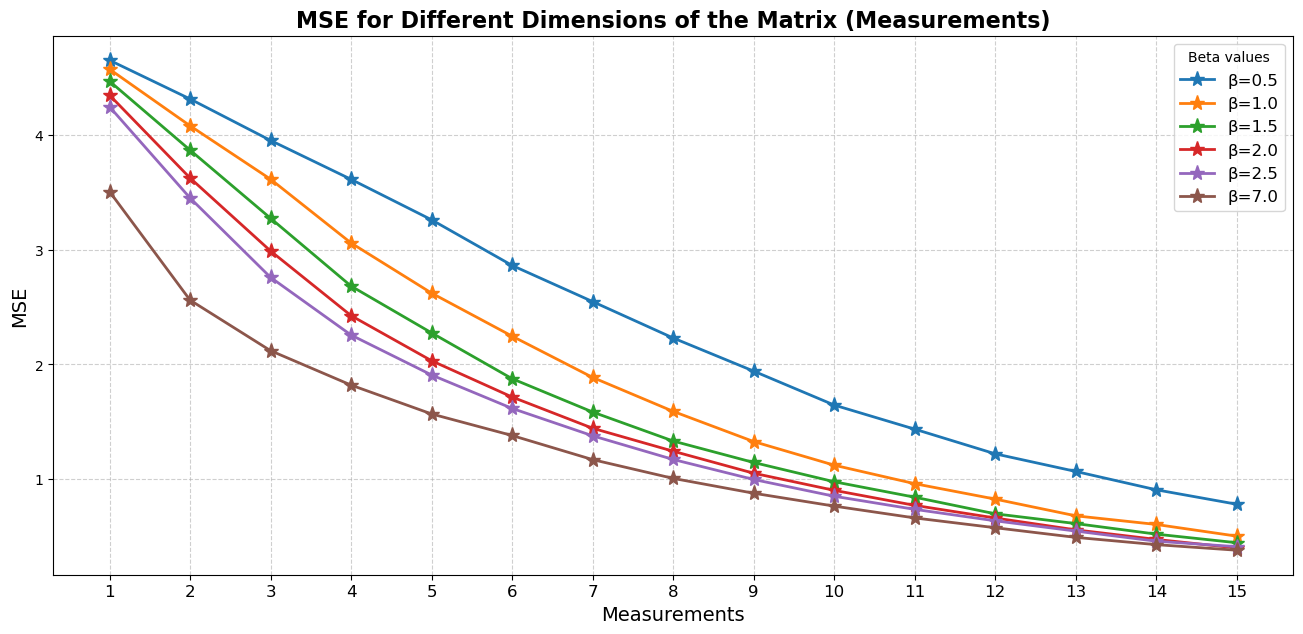

In [56]:
#Behavior of estimates for different values of beta while maintaining the same M and N
#parameters
M = 10000  # number of realizations of the Metropolis-Hastings
N = 100  # number of steps of the Metropolis-Hastings
d = 10  # state space dimension
max_row_matrix = 15
betas = [0.5, 1.0, 1.5, 2.0, 2.5, 7.0]
results = []

#compute the MSE for different Betas
for beta in betas:
    MSE_for_different_B = mean_sq_error(max_row_matrix, M, beta, N, d)
    results.append(MSE_for_different_B)


matrix_dimension = list(range(1, 16))
plt.figure(figsize=(16, 7))

for idx, beta in enumerate(betas):
    plt.plot(matrix_dimension, results[idx], marker='*', linestyle='-', markersize=11, linewidth=2, label=f'β={beta}')

plt.title('MSE for Different Dimensions of the Matrix (Measurements)', fontsize=16, fontweight='bold')
plt.xlabel('Measurements', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(matrix_dimension, fontsize=12)
plt.legend(title='Beta values', fontsize=12)
plt.show()

In [57]:
#MSE results with different betas
for i in results:
    print(i)

[4.6492, 4.312, 3.9509, 3.612, 3.2596, 2.8624, 2.5476, 2.2307, 1.9421, 1.6466, 1.4369, 1.222, 1.0687, 0.909, 0.783]
[4.5713, 4.0785, 3.6132, 3.0578, 2.6215, 2.2466, 1.8873, 1.5918, 1.3288, 1.1232, 0.9621, 0.8278, 0.6823, 0.6071, 0.5053]
[4.4668, 3.8667, 3.2732, 2.6826, 2.2754, 1.8762, 1.5861, 1.3334, 1.1467, 0.979, 0.8443, 0.6998, 0.6148, 0.5228, 0.448]
[4.3455, 3.624, 2.9884, 2.4254, 2.0327, 1.7166, 1.4448, 1.2449, 1.0532, 0.9042, 0.7733, 0.6633, 0.56, 0.4769, 0.4023]
[4.2443, 3.4499, 2.7585, 2.2564, 1.9086, 1.6175, 1.3791, 1.1731, 0.9987, 0.8527, 0.7387, 0.6388, 0.5494, 0.4614, 0.4136]
[3.5061, 2.5606, 2.1202, 1.8205, 1.5693, 1.3817, 1.1717, 1.0083, 0.8791, 0.7669, 0.664, 0.5786, 0.4946, 0.4313, 0.3828]


<h3>Analysis with different realizations (M) of the Metropolis-Hasting Algorithm</h3>

MSE m=1: 4.328
MSE m=2: 3.68
MSE m=3: 2.951
MSE m=4: 2.512
MSE m=5: 2.072
MSE m=6: 1.734
MSE m=7: 1.553
MSE m=8: 1.233
MSE m=9: 1.056
MSE m=10: 0.848
MSE m=11: 0.801
MSE m=12: 0.663
MSE m=13: 0.599
MSE m=14: 0.554
MSE m=15: 0.415
MSE m=1: 4.394666666666667
MSE m=2: 3.6296666666666666
MSE m=3: 2.961
MSE m=4: 2.453
MSE m=5: 2.0203333333333333
MSE m=6: 1.676
MSE m=7: 1.426
MSE m=8: 1.2393333333333334
MSE m=9: 1.069
MSE m=10: 0.9123333333333333
MSE m=11: 0.743
MSE m=12: 0.6673333333333333
MSE m=13: 0.5326666666666666
MSE m=14: 0.4676666666666667
MSE m=15: 0.435
MSE m=1: 4.374
MSE m=2: 3.629
MSE m=3: 2.962
MSE m=4: 2.456
MSE m=5: 2.0308
MSE m=6: 1.7042
MSE m=7: 1.4456
MSE m=8: 1.2204
MSE m=9: 1.0224
MSE m=10: 0.9064
MSE m=11: 0.7736
MSE m=12: 0.6526
MSE m=13: 0.5562
MSE m=14: 0.487
MSE m=15: 0.4314
MSE m=1: 4.3482666666666665
MSE m=2: 3.6573333333333333
MSE m=3: 2.9634666666666667
MSE m=4: 2.4204
MSE m=5: 2.0232
MSE m=6: 1.7165333333333332
MSE m=7: 1.4465333333333332
MSE m=8: 1.2648
MSE m=9

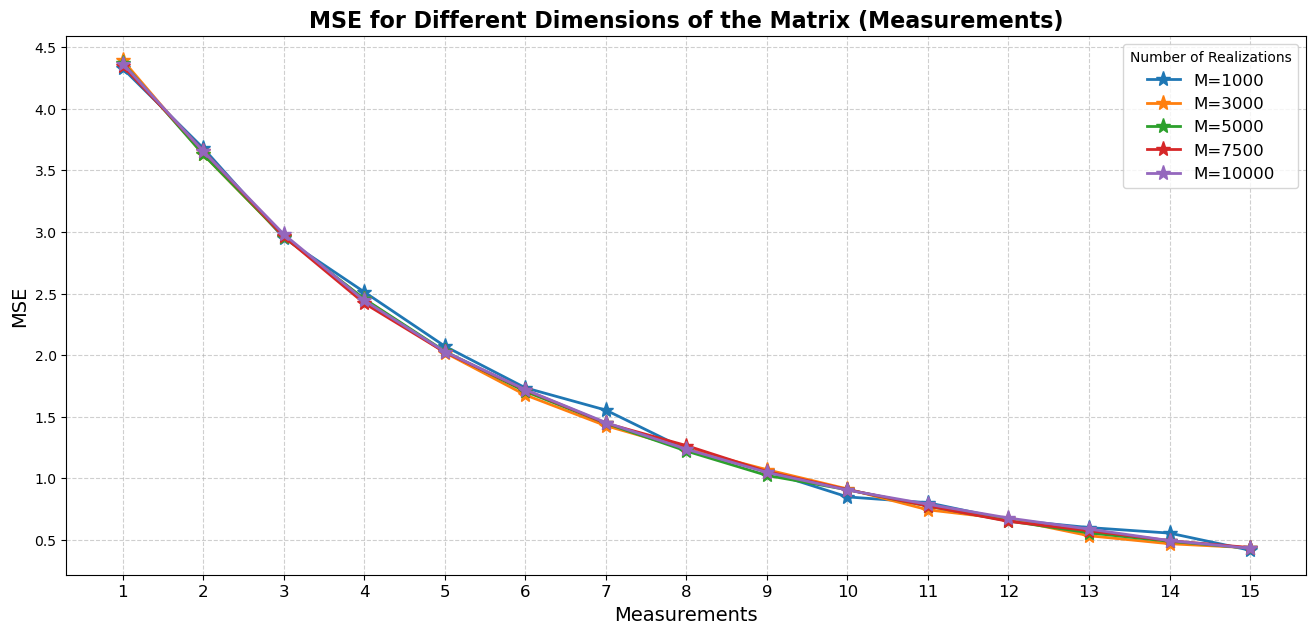

In [59]:
#parameters
B = 2.0  # value of beta
N = 100  # number of steps of the metropolis-hasting
d = 10  #state space
realizations = [1000, 3000, 5000, 7500, 10000]
max_row_matrix = 15
results_M = []

#compute the mse for different values of M
results_M = [mean_sq_error(max_row_matrix, r, B, N, d) for r in realizations]

#plotting the MSE
matrix_dimension = list(range(1, 16))
plt.figure(figsize=(16, 7))

for idx, r in enumerate(realizations):
    plt.plot(matrix_dimension, results_M[idx], marker='*', linestyle='-', markersize=11, linewidth=2, label=f'M={r}')

plt.title('MSE for Different Dimensions of the Matrix (Measurements)', fontsize=16, fontweight='bold')
plt.xlabel('Measurements', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(matrix_dimension, fontsize=12)
plt.legend(title='Number of Realizations', fontsize=12)
plt.show()

In [60]:
#MSE results with different M
for i in results_M:
    print(i)

[4.328, 3.68, 2.951, 2.512, 2.072, 1.734, 1.553, 1.233, 1.056, 0.848, 0.801, 0.663, 0.599, 0.554, 0.415]
[4.394666666666667, 3.6296666666666666, 2.961, 2.453, 2.0203333333333333, 1.676, 1.426, 1.2393333333333334, 1.069, 0.9123333333333333, 0.743, 0.6673333333333333, 0.5326666666666666, 0.4676666666666667, 0.435]
[4.374, 3.629, 2.962, 2.456, 2.0308, 1.7042, 1.4456, 1.2204, 1.0224, 0.9064, 0.7736, 0.6526, 0.5562, 0.487, 0.4314]
[4.3482666666666665, 3.6573333333333333, 2.9634666666666667, 2.4204, 2.0232, 1.7165333333333332, 1.4465333333333332, 1.2648, 1.0541333333333334, 0.9072, 0.7742666666666667, 0.6492, 0.5736, 0.4922666666666667, 0.43666666666666665]
[4.3669, 3.6552, 2.9813, 2.4432, 2.0278, 1.7186, 1.4522, 1.2355, 1.0474, 0.9033, 0.7881, 0.6766, 0.5864, 0.4932, 0.4303]


<h3>What is the minimum value of m/d required to reliably recover θ?</h3>

MSE m=1: 4.396
MSE m=2: 3.6487
MSE m=3: 2.9793
MSE m=4: 2.4226
MSE m=5: 2.0038
MSE m=6: 1.7223
MSE m=7: 1.4561
MSE m=8: 1.2187
MSE m=9: 1.0454
MSE m=10: 0.8984
MSE m=11: 0.7552
MSE m=12: 0.6566
MSE m=13: 0.5776
MSE m=14: 0.4961
MSE m=15: 0.4239


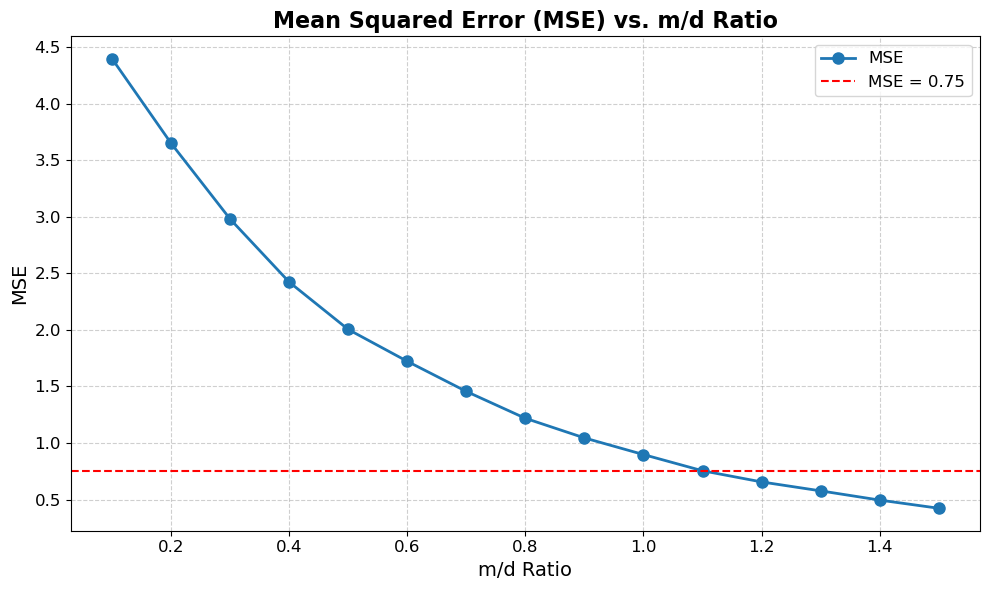

In [13]:
# Parameters
M = 10000  #Number of realizations of the Metropolis-Hastings
N = 100  #Number of steps of the Metropolis-Hastings
d = 10  #State space dimension
max_row_matrix = 15  #Maximum number of measurements
beta = 2.0  #Fixed value of beta

#Compute MSE for different values of m/d
results = mean_sq_error(max_row_matrix, M, beta, N, d)

#Plotting
matrix_dimension = list(range(1, max_row_matrix + 1))
m_over_d_values = [m / d for m in matrix_dimension]

plt.figure(figsize=(10, 6))
plt.plot(m_over_d_values, results, marker='o', linestyle='-', markersize=8, linewidth=2, label='MSE')

# Adding the reference line MSE = 0.75
plt.axhline(y=0.75, color='r', linestyle='--', label='MSE = 0.75')

plt.title('Mean Squared Error (MSE) vs. m/d Ratio', fontsize=16, fontweight='bold')
plt.xlabel('m/d Ratio', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()